# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [3]:
# Perform K-Means Clustering on the Dataset

df["Unnamed: 32"].value_counts(dropna = False)

NaN    569
Name: Unnamed: 32, dtype: int64

* That last column is made up entirely of Nans
* First column, ID, can be used as an index

In [4]:
df = df.set_index('id', verify_integrity=True).drop('Unnamed: 32', axis=1)
diag_df = df['diagnosis'].copy()
df = df.drop('diagnosis', axis=1)
orig_df = df.copy()
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
df.shape

(569, 30)

* Radius sounds like a big marker. Let's graph that against the other columns to see if there's any clustering going on.

In [0]:
def scatter_plot(df, x_key:str, y_key:str):
  df.plot(x_key, y_key, kind = 'scatter', legend = True)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


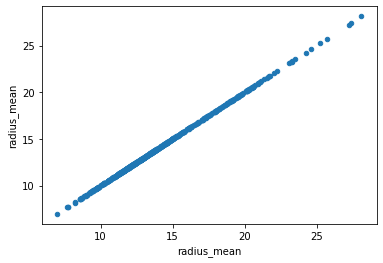

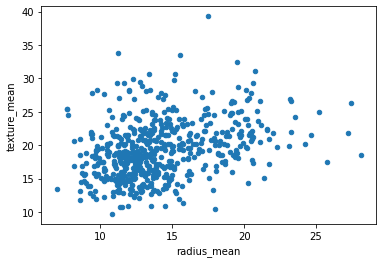

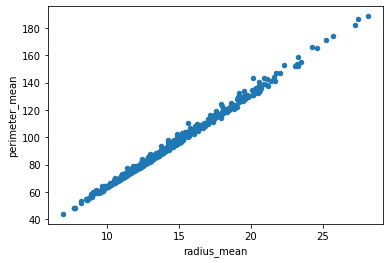

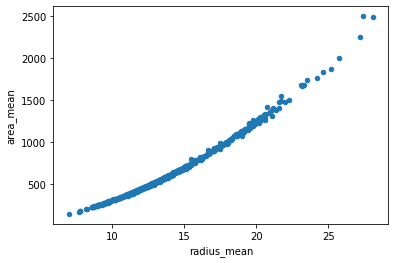

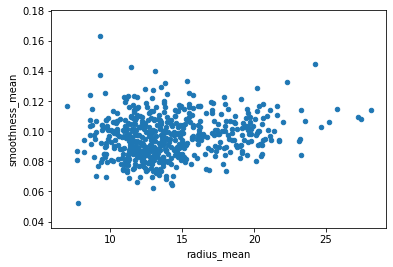

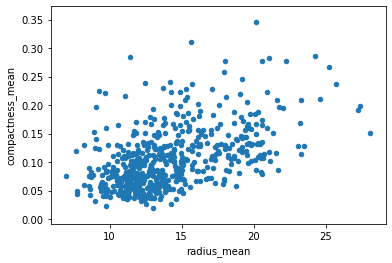

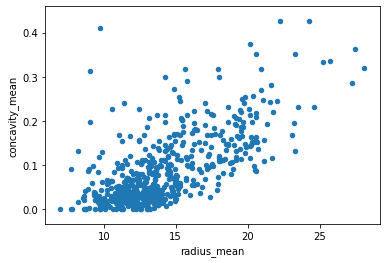

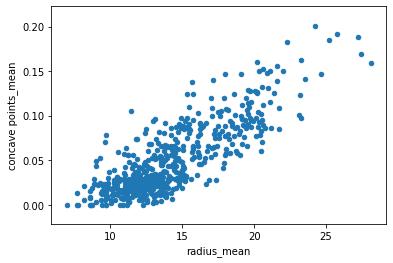

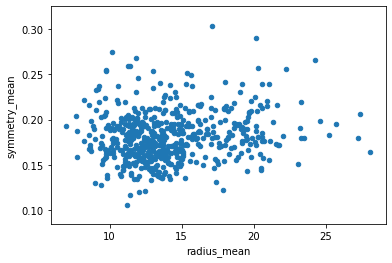

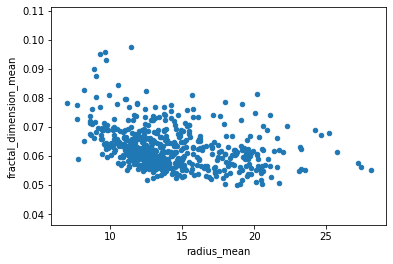

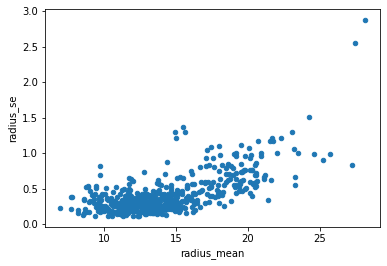

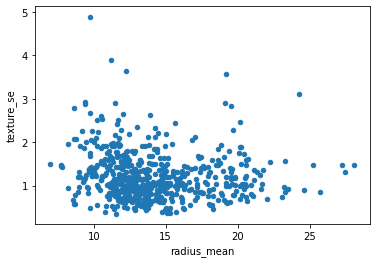

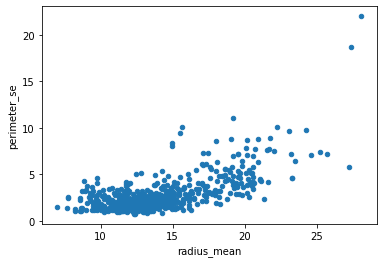

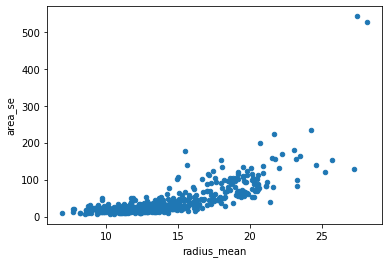

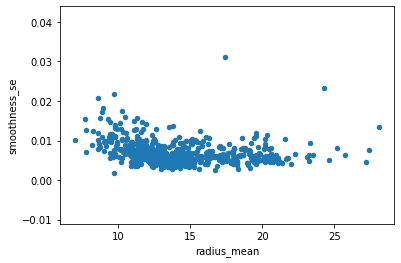

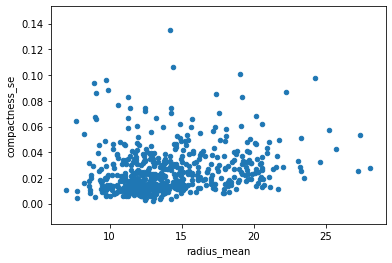

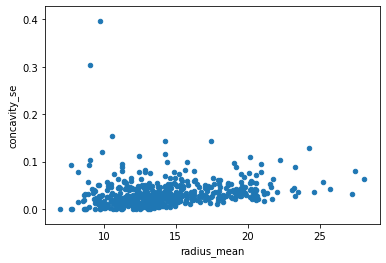

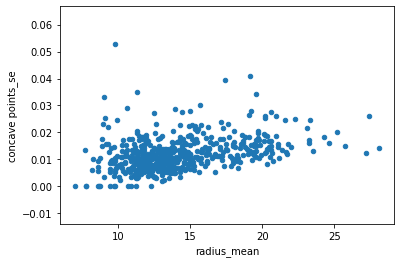

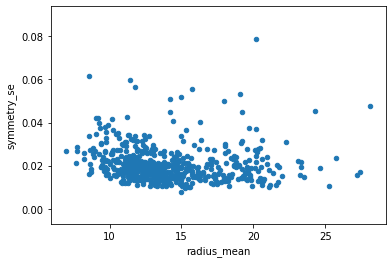

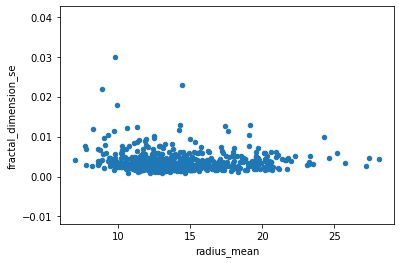

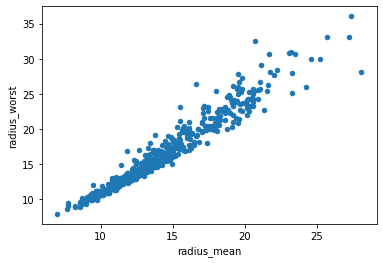

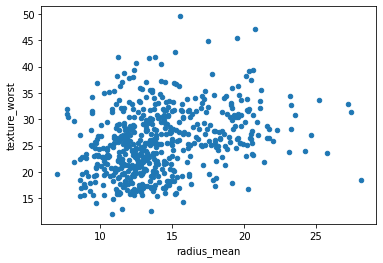

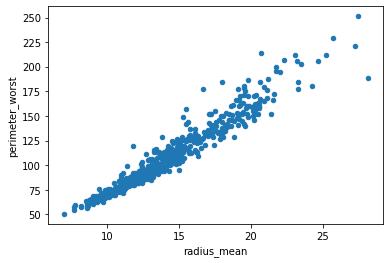

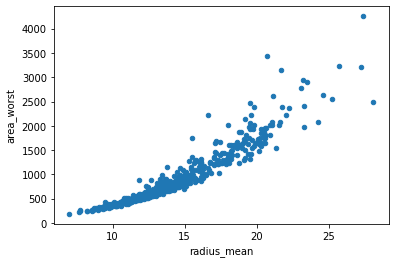

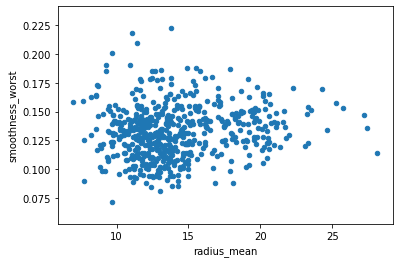

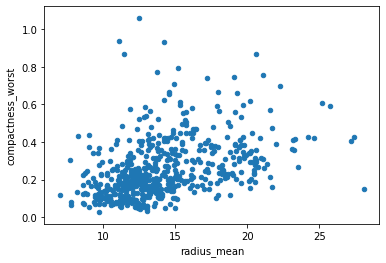

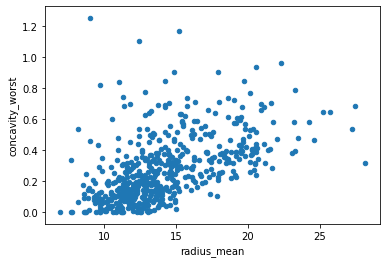

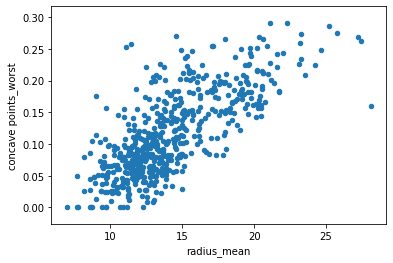

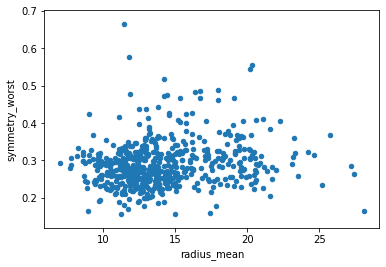

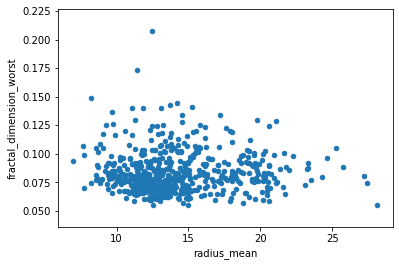

In [7]:
columns = df.columns.tolist()
x = columns[0]
for y in columns:
  scatter_plot(df, x, y)


* Nothing is great. Maybe `Smoothness_mean` vs `radius_mean`?

In [0]:
features = ['radius_mean', 'smoothness_mean']

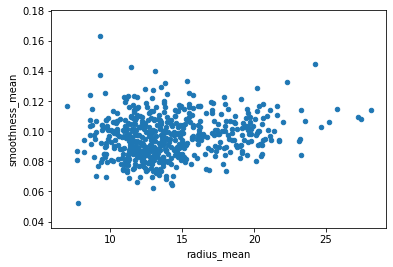

In [9]:
scatter_plot(df, *features)

Let's start K-Clustering. We should determine the best $K$

In [0]:
def plot_Kscree(points):
  sum_of_squared_distances = []
  K = range(1,15)
  for k in K:
      km = KMeans(n_clusters=k)
      km = km.fit(points)
      sum_of_squared_distances.append(km.inertia_)
  plt.plot(K, sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

In [0]:
def plot_pca_scree(pca ):
  vals = pca.explained_variance_ratio_
  num_components=len(pca.explained_variance_ratio_)
  ind = np.arange(num_components)
  plt.bar(ind, vals)
  explained = 0
  #for i, val in zip(range(len(vals), vals.values)):
  #  explained += val
  #  if explained + 0.9:
  #    return i + 1

In [0]:
def perform_KMeans(df, k, plot = True):
  df = df.copy()
  features = df.columns.tolist()
  model = KMeans(n_clusters=k)
  model.fit(df.values)
  df['cluster'] = model.labels_
  if plot:
    centroids = model.cluster_centers_
    cc = pd.DataFrame(centroids)
    base_colors = ['r', 'g', 'b', 'c', 'm']
    colors = [base_colors[centroid] for centroid in model.labels_]
    fig, ax = plt.subplots(figsize=(7,6))
    ax.scatter(df[features[0]], df[features[1]], c=colors)
  return df

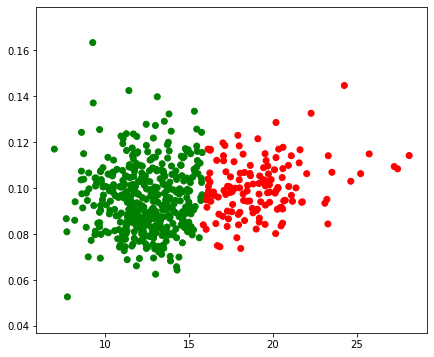

In [13]:
df = perform_KMeans(df[features], 2)

In [0]:
df['diagnosis'] = diag_df

In [15]:
df[['cluster', 'diagnosis']].head(25)

,cluster,diagnosis
id,,
842302,0,M
842517,0,M
84300903,0,M
84348301,1,M
84358402,0,M
843786,1,M
844359,0,M
84458202,1,M
844981,1,M


## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [0]:
# Your Code Here
# Let's assume cluster 0 is Benign, cluster 1 is Malignant

def get_accuracy(df):


  true_positive = (df['cluster'] == 1) & (df['diagnosis'] == 'M')
  true_negative = (df['cluster'] == 0) & (df['diagnosis'] == 'B')
  correct = true_positive | true_negative
  correct_df = df[correct]
  num_correct = df[correct].shape[0]
  total = df.shape[0]
  return (f'{num_correct/total:.2%}')

In [17]:
print(f'The accuracy = {get_accuracy(df)}')

The accuracy = 14.41%


# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [0]:
##### Your Code Here #####

In [0]:
# Lets drop diagnosis again
df2 = orig_df.copy()

In [0]:
scaler = StandardScaler()

In [40]:
scaled_df = pd.DataFrame(scaler.fit_transform(df2))
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,2.489734,-0.565265,2.833031,2.487578,-0.214002,1.316862,0.724026,0.660820,1.148757,0.907083,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,0.499255,-0.876244,0.263327,0.742402,-0.605351,-0.692926,-0.440780,0.260162,-0.805450,-0.099444,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,1.228676,-0.780083,0.850928,1.181336,-0.297005,0.814974,0.213076,1.424827,0.237036,0.293559,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,0.326373,-0.110409,0.286593,-0.288378,0.689702,2.744280,0.819518,1.115007,4.732680,2.047511,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,1.270543,-0.790244,1.273189,1.190357,1.483067,-0.048520,0.828471,1.144205,-0.361092,0.499328,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [0]:
pca = PCA(n_components=2)

In [51]:
pca2_df = pd.DataFrame(pca.fit_transform(scaled_df), columns=['x','y'], index=df2.index)
pca2_df

,x,y
id,,
842302,9.192837,1.948583
842517,2.387802,-3.768172
84300903,5.733896,-1.075174
84348301,7.122953,10.275589
84358402,3.935302,-1.948072
...,...,...
926424,6.439315,-3.576817
926682,3.793382,-3.584048
926954,1.256179,-1.902297


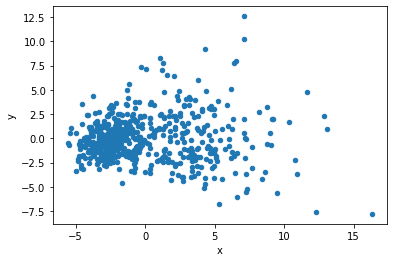

In [34]:
scatter_plot(pca2_df, 'x', 'y')

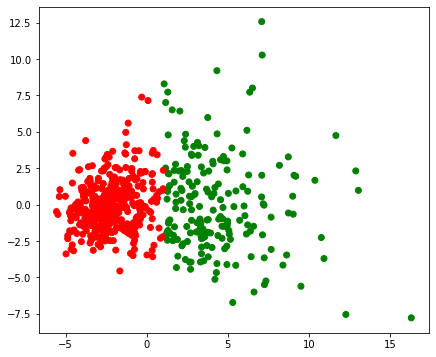

In [43]:
pca2_df = perform_KMeans(pca2_df,2)

In [0]:
pca10 = PCA(10)

In [0]:
pca10_df = pd.DataFrame(pca10.fit_transform(scaled_df), index=df2.index)

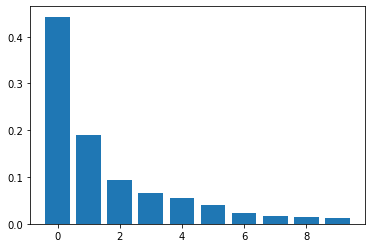

In [52]:
plot_pca_scree(pca10)

In [0]:
def get_geq90(pca ):
  vals = pca.explained_variance_ratio_
  num_components=len(pca.explained_variance_ratio_)
  ind = np.arange(num_components)

  explained = 0
  for i, val in zip(ind, vals):
    explained += val
    print(explained)
    if explained >= 0.9:
      return i + 1

In [61]:
get_geq90(pca10)

0.4427202560752638
0.6324320765155944
0.7263637090899083
0.7923850582446099
0.8473427431680723
0.8875879635669057
0.910095300696722


7

In [0]:
pca7 = PCA(7)

In [0]:
pca7_df = pd.DataFrame(pca7.fit_transform(scaled_df), index=df2.index)

In [0]:
pca7_df = perform_KMeans(pca7_df,2, False)

In [0]:
pca7_df['diagnosis'] = diag_df

In [74]:
get_accuracy(pca7_df)

'91.21%'

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [44]:
pca2_df['diagnosis'] = diag_df
get_accuracy(pca2_df)

'90.69%'

In [75]:
get_accuracy(pca7_df)

'91.21%'

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project